In [1]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from stemmer import Stemmer

In [ ]:
from gensim.test.utils import datapath
from gensim import utils
import pandas as pd

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""
    
    stop_list = ['.', ',', '"', ')', '(', ':', ';', '?', '!', '\'', '–', '-', '{', '}', '\xa0']
    
    def __init__(self):
        self.df = pd.read_csv("data/short_reviews_bert_10_1_50.csv")
        self.df.drop_duplicates(inplace=True)
        self.stemmer = Stemmer("root_dict.json")
        
        self.df_copy = self.df.copy()
        self.df_copy['content'] = self.df_copy['content'].apply(self.sanitize_text)
        self.X = self.df_copy['content'].to_numpy()
        self.y = self.df_copy['rating'].to_numpy()
        
    def __iter__(self):
        for row in self.X:
            yield row.split(" ")       
        
    def sanitize_text(self, text):
        temp = text.lower()
        for element in MyCorpus.stop_list:
            temp = temp.replace(element, " ")

        for j in range(10):
            temp = temp.replace("  ", " ")

        temp = temp.split(" ")
        stemmed_text = ""
        for word in temp:
            found = self.stemmer.find(word) 
            if found:
                stemmed_text += found.replace(" ","") #sometimes word has space in the end
            else:
                stemmed_text += word
            stemmed_text += " "

        return stemmed_text[:-1]
        
    
#     def __iter__(self):
#         corpus_path = datapath('lee_background.cor')
#         for line in open(corpus_path):
#             # assume there's one document per line, tokens separated by whitespace
#             yield utils.simple_preprocess(line)

In [ ]:
c = MyCorpus()

In [ ]:
for i in c:
    print(i)
    break

In [ ]:
model = gensim.models.Word2Vec(sentences=c, min_count=30, size=300, workers=12, window=5)

In [ ]:
from collections import defaultdict
# vecs = defaultdict(list)
X = []
y = c.y

index_to_word = defaultdict(str)

for i, word in enumerate(model.wv.vocab):
    X.append(model.wv[word])
    index_to_word[i] = word

In [ ]:
X = np.array(X)

In [ ]:
print(X.shape)

In [ ]:
len(c.df)

In [37]:
from sklearn.neighbors import NearestNeighbors
N = 10
nn = NearestNeighbors(n_neighbors = N)
nn.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [ ]:
search1 = np.array(model.wv['przeciętniak'])
search2 = np.array(model.wv['arcydzieło'])
search1 = search1.reshape(1, -1)
search2 = search2.reshape(1, -1)

dist1, out1 = nn.kneighbors(search1)
dist2, out2 = nn.kneighbors(search2)

In [ ]:
print("negatywne===============================================")
negative = []
for i, index in enumerate(out1[0]):
    print(index_to_word[index], dist1[0][i])
    negative.append(index_to_word[index])

    
print("pozytywne===============================================")
positive = []
for i, index in enumerate(out2[0]):
    print(index_to_word[index], dist2[0][i])
    positive.append(index_to_word[index])

In [40]:
np.linalg.norm(np.array(model.wv['przeciętniak']) - np.array(model.wv['arcydzieło']))

8.671405

In [41]:
# print(X[0])
pd.options.display.max_colwidth = 1500
# print(synoms)
chosen_y = []
# for i, comment in 

positive_representations = [model.wv[x].reshape(1, -1)[0] for x in positive]
negative_representations = [model.wv[x].reshape(1, -1)[0] for x in negative]
# for word in 


def find_closest(word):
    try:
        w1 = np.array(model.wv[word])
    except:
        return None
#     print(w1)
#     print(positive_representations[0])
#     positive = True
    pos_avg = 0
    neg_avg = 0
    mins = np.linalg.norm(w1 - positive_representations[0])
    for vec in positive_representations[1:]:
         pos_avg += np.linalg.norm(w1 - vec)
        
    for vec in negative_representations:
        neg_avg -= np.linalg.norm(w1 - vec)


    return 1/(pos_avg/N) - 1/(neg_avg/N)

outcome = []

for i, comment in enumerate(tqdm(c.X[:5000])):
    sums = 0
    for word in comment.split(" "):
        out = find_closest(word)
        if out is None: continue
        sums += out
    outcome.append([c.df.iloc[i]['content'], c.df.iloc[i]['rating'], sums/len(comment.split(" "))])
#     break
# #     print(comment)
#     for syn in synoms:
        
#         if syn in comment.split(" "):
#             print(c.df.iloc[i])
#             chosen_y.append(int(c.y[i]))

100%|██████████| 5000/5000 [00:16<00:00, 295.18it/s]


In [42]:
df_out = pd.DataFrame(outcome)

# df_out = pd.DataFrame(outcome)
# # df_out['temp']
# df_out['content'] = c.df['content']
# df_out['rating'] = c.df['rating']

df_out.head(50)

,0,1,2
0,"Z każdym kolejnym razem, ten film wydaje mi się lepszy. Oglądam go średnio co 2 lata i za każdym razem ktoś mi kroi cebulę przed nosem. Według mnie była to rola życia Duncana, zagrał po mistrzowsku.",9,0.181457
1,"Mamy tutaj do czynienia z typowym amerykańskim wylewaczem łez. Film jest przeciętny i nic poza tym, zawsze gdy atakuję go w obecności znajomych zadają mi pytanie ""czy płakałem"". Otóż nie, wzruszyłem się, to prawda, ale czy to od razu powód aby wystawiać mu dychę? Nie sądzę. Moje wzruszenie zostało kupione tanimi chwytami z którymi miałem już styczność wielokrotnie, Wszystko jest niesamowicie ...",4,0.306392
2,lecz jeśli znasz kogoś kto oglądał ten film i nie płakał to WIEDZ że coś się dzieje.,10,0.221311
3,"że gdyby nie płonąca scena egzekucji,mógłby robić zamiast""Domku na prerii""dla mało rozgarniętej dziatwy ze szkółki niedzielnej.Nieprawdziwe postacie,strażnicy o gołębich sercach skumplowani ze skazancami,a samo wiezienie-jak senatorium.Goscie mają Coffeya,objawienie,-nie wiem-tak jakby sam Jezus,albo jakiś kosmita zszedł na Ziemię-a oni ...",5,0.236264
4,Dopiero po przeczytaniu książki i obejrzeniu filmu poraz drugi zauważyłem że temu filmowi należy się zdecydowane 10.Genialny.Role Toma Hanksa i Michaela Clarka Duncana idealne.,10,0.229769
5,Na pogrzebie własnego syna nie płakałem tak jak na tym filmie,9,0.295020
6,"Jeden z najlepszych filmów jakie widziałem. Genialny w każdym calu, historia przedstawiona jak trzeba, rewelacyjna gra aktorska, świetna fabuła, doskonałe przesłanie, odpowiedni klimat oraz muzyka. Jest to jeden z filmów który można oglądać kilka razy i po latach przypuszczam również będzie zdawał egzamin. 10/10.",10,0.227055
7,"Zaczęło się pewnie od jakiegoś nawiedzinego gościa w serwisie FilWebu... podkręcił sztucznie pierwsze 100 tys głosów – i cieszył się widząc jak ludzie oglądają to co im polecił. Potem mógł nawet odjąć te extra głosy – jak się maszynka zaczęła kręcić – to działa już jak perpetum mobile...Ja, w każdym razie, dałem się złapać. Po przeczytaniu opisu filmu ...",4,0.260773
8,"Zacznijmy od tego, że King to grafoman, choć nie aż tak wielki jak np. banalista Coelho. O samym filmie wszystko już powiedział pewien Ichabod (on naprawdę ma rację, co może trudno dostrzec przez tę przytłaczającą charyzmę), więc zapraszam do obejrzenia mini-recki: http://www.youtube.com/watch?v =HQ01tuxOwPkDobre filmy to robili Kurosawa, P. T. Anderson, Bergman... Darabont, Spielberg, Cameron, Nolan, ...",3,0.263590
9,"Zacznę w sposób kurtularny, gdyż nie chcę byście donosili i konfidentowali na mnie :). Uważam, że ten film to jest porażka kinematografii, TAKIEgo tragicznego filmu ze świecą szukac w czeluściach Charona.Argumenty :1. Zacznijmy od głównego bohatera. Ten duży murzyn jest za duży, stanowczo za duży. Nie ma takiego wielkiego człowieka na świecie i nigdy nie było, moim zdaniem dawanie tego do ...",5,0.232572


In [34]:
df_out.sort_values(by=2, ascending=False).head(20)

,0,1,2
2733,"Marlon Brando zmiażdżył Pacino palcem. Koniec, kropka.",10,0.615175
498,"Natalie- rewelacja, Jean Reno- rewelacja, Gary Oldman- wow, wow, wow ....",10,0.608704
3655,25 maja nasz kochany Gandalf obchodzi 70 urodziny. ;),10,0.552316
704,"Wspaniały, ale przytłaczający, taki smutniejszy Trainspotting.",7,0.512179
4616,"Sylvester Stallone oficjalnie potwierdził, że Wilson zagra w Niezniszczalni 3.",9,0.508319
556,"!1!Gary Oldman-""Leon""!2!Heat h Ledger-""The Dark Knight""!3!Anthony Perkins-""Psycho""",7,0.487364
3138,wybuchowa dawka śmiechu :)))zdjęcia na końcu- bezcenne ;P,8,0.470084
1545,Najlepsze dialogi pod słońcem ;) Motyw bajki w krzywym zwierciadle cudny ;D,9,0.469560
4723,"""Park Jurajski"" najlepszym filmem Spielberga A.D.1993",2,0.449545
1016,oczywiście zawsze znajdą się amatorzy zafascynowani banalnym złem,3,0.448010


In [36]:
df_out.sort_values(by=2, ascending=True).iloc[0:50]

,0,1,2
3654,cuuuuuuuuudoooooooooooooooo!!! !!!!kochamgoooooooooo,9,0.000000
4109,Ich habe eine Pistole auf Ihre Eier gerichtet seit Sie hier sitzen.Brylant aktorski!,9,0.056721
1982,http://1.asset.soup.io/asset/3 108/7057_2d73_480.jpeg hahahaha <3,10,0.068443
2300,http://images.wikia.com/fanows ka-my-little-pony/pl/images/a/ a0/Rzygam-tecza.jpg,9,0.071687
2732,https://paranormalpl.wordpress .com/2010/09/05/duch-na-filmow ym-pogrzebie/,9,0.073004
1631,Ciekawy demothttp://demotywatory.pl/2099966 /Lord-Farquaad:),10,0.074959
2584,ZAPRASZAM -http://tohavefabulousday.blog spot.com/2014/04/nietykalni.ht ml,9,0.080262
2079,http://brudnopisarz.blog.pl/20 17/04/18/dlaczego-kochamy-tita nica/,10,0.084754
4833,http://img844.imageshack.us/im g844/9014/1832741.jpg,10,0.099025
3282,Jakie znacie oprócz:Shutter IslandSzósty zmysłShawshank RedemptionFight ClubDevil's Advocate,8,0.099359


In [342]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [343]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(X[:5000])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.100s...
[t-SNE] Computed neighbors for 5000 samples in 8.684s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.649092
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.012314
[t-SNE] KL divergence after 1050 iterations: 1.979308


In [182]:
y_pred = []
for vect in X:
    if np.linalg.norm(np.array(vect) - search2[0]) < 2:
        y_pred.append(1)
    elif np.linalg.norm(np.array(vect) - search1[0]) < 2:
        y_pred.append(2)
    else:
        y_pred.append(0)

In [183]:
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

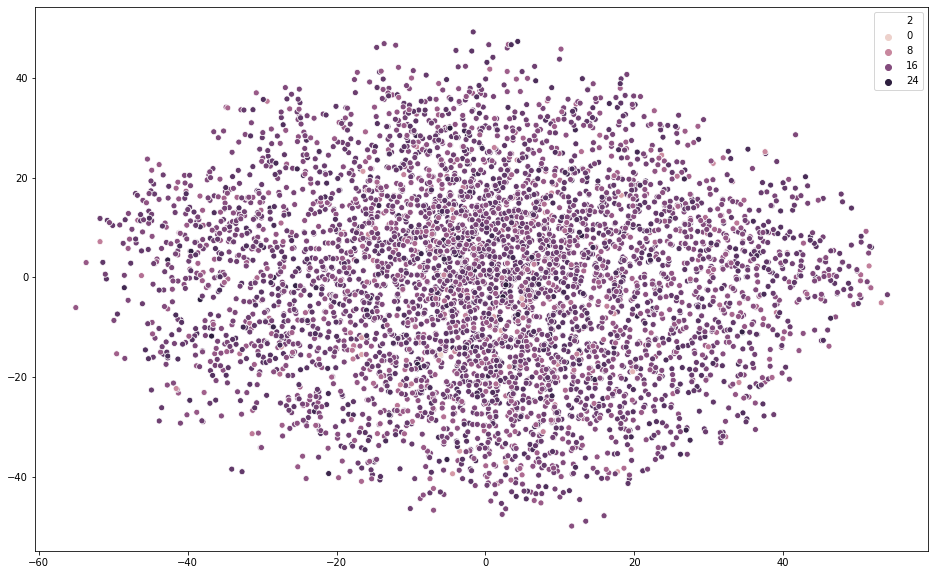

In [344]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=df_out[2],
#     palette=sns.color_palette("hls", 10),
#     data=X,
#     legend="full",
    alpha=1
)